# Synthesizing the chronology of late Mesoproterozoic Laurentia tectonics

## Import scientific Python packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.ticker as tck
import matplotlib
import seaborn as sns
%config InlineBackend.figure_format='retina'

## Import compiled data

In [2]:
dates = pd.read_csv('data/Mesoproterozoic_Laurentia_dates.csv')
dates.columns

Index(['Sample_No', 'Age', 'Error_Plus', 'Error_Minus', 'Age_Method',
       'Age_Interpretation', 'Age_Note', 'Age_Material', 'Age_Technique',
       'Age_Qualifier', 'Geological_Province', 'Province', 'Latitude',
       'Longitude', 'Location', 'Geological_Info', 'Rock_Type',
       'Rock_Description', 'References', 'Compilation_Source', 'Unnamed: 20',
       'UTM_Zone', 'UTM_Easting', 'UTM_Northing', 'Comment', 'Tectonic_Unit'],
      dtype='object')

## Define legend symbology

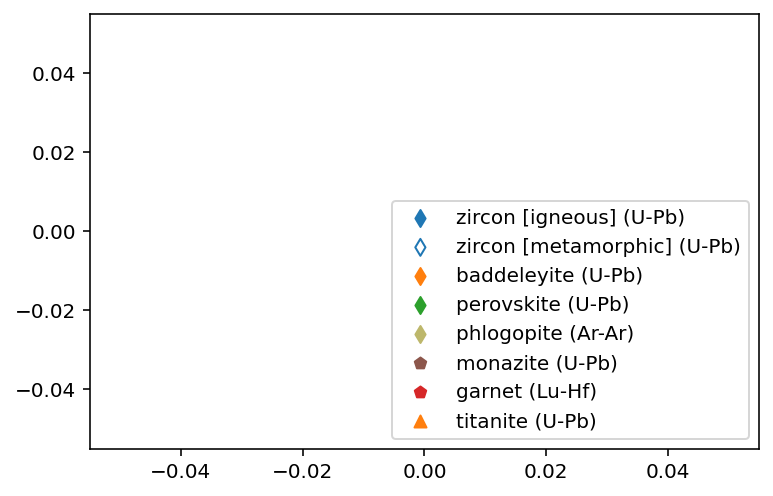

In [3]:
zircon_marker = plt.scatter([], [], c='C0', marker='d', label='zircon [igneous] (U-Pb)')
zircon_rim_marker = plt.scatter([], [], edgecolors='C0', color='none', marker='d', label='zircon [metamorphic] (U-Pb)')
bad_marker = plt.scatter([], [], c='C1', marker='d', label='baddeleyite (U-Pb)')
perov_marker = plt.scatter([], [], c='C2', marker='d', label='perovskite (U-Pb)')
phlog_marker = plt.scatter([], [], c='darkkhaki', marker='d', label='phlogopite (Ar-Ar)')
monazite_marker = plt.scatter([], [], marker='p',c='C5',label='monazite (U-Pb)')
garnet_marker = plt.scatter([], [], marker='p',color='C3',label='garnet (Lu-Hf)')
titanite_marker = plt.scatter([], [], marker='^',c='C1',label='titanite (U-Pb)')
plt.legend(handles=[zircon_marker,zircon_rim_marker,bad_marker,perov_marker,phlog_marker,monazite_marker,garnet_marker,titanite_marker],loc=4)
plt.show()

## Implement bootstrap method for duration estimates

In [4]:
def bootstrap_calc_plot(dates,bootstrap_n=10000,kde_bandwidth=0.8,plot=True):

    bootstrapped_mins = []
    bootstrapped_maxs = []

    for i in range(0,bootstrap_n):

        bootstrapped_dates = []

        resampled_data = dates.sample(n=len(dates),replace = True)
        resampled_data.reset_index(inplace=True)

        for n in resampled_data.index:
            bootstrapped_date = np.random.normal(resampled_data.Age[n], resampled_data.Error_Plus[n]/2, 1)
            bootstrapped_dates.append(bootstrapped_date[0])

        bootstrapped_mins.append(np.min(bootstrapped_dates)) 
        bootstrapped_maxs.append(np.max(bootstrapped_dates)) 
        if plot==True:
            if 1000-i > 0:
                sns.kdeplot(bootstrapped_dates,bw_adjust=kde_bandwidth,alpha=0.5,color='grey',shade=False,linewidth=0.1)
    
    if plot==True:
        sns.kdeplot(dates.Age,bw_adjust=kde_bandwidth,color='black')
            
    max_age = np.percentile(bootstrapped_maxs,5)
    min_age = np.percentile(bootstrapped_mins,95)
    
    return bootstrapped_maxs,bootstrapped_mins,max_age,min_age

def plot_bootstrap_hist(bootstrapped_maxs,bootstrapped_mins,max_age,min_age,age_range_max=1200,age_range_min=1100,ylim='hist_max'):
    hist_min = plt.hist(bootstrapped_mins,bins=np.arange(age_range_min,age_range_max,0.5),label='bootstrap min',color='#F8C471')
    hist_max = plt.hist(bootstrapped_maxs,bins=np.arange(age_range_min,age_range_max,0.5),label='bootstrap max',color='#48C9B0')
    rect = patches.Rectangle((min_age, 0), max_age-min_age, np.max(hist_max[0])*30, facecolor='lightgrey',zorder=-1,label=
                        'duration estimate')
    plt.gca().add_patch(rect)
    if ylim == 'hist_max':
        plt.ylim(0,np.max(hist_max[0])*1.1)
    if ylim == 'hist_min':
        plt.ylim(0,np.max(hist_min[0])*2)

In [5]:
bootstrap_number = 10000

## AMCG

In [6]:
AMCG_dates = dates[(dates.Geological_Info == 'AMCG') | (dates.Geological_Info == 'AMCG-A')]
AMCG_dates = AMCG_dates[AMCG_dates.Age_Interpretation == 'Igneous']
AMCG_dates = AMCG_dates.sort_values('Age',ascending=False)
AMCG_dates.reset_index(inplace=True)

AMCG_anorthosite = AMCG_dates[(AMCG_dates.Geological_Info == 'AMCG-A')]

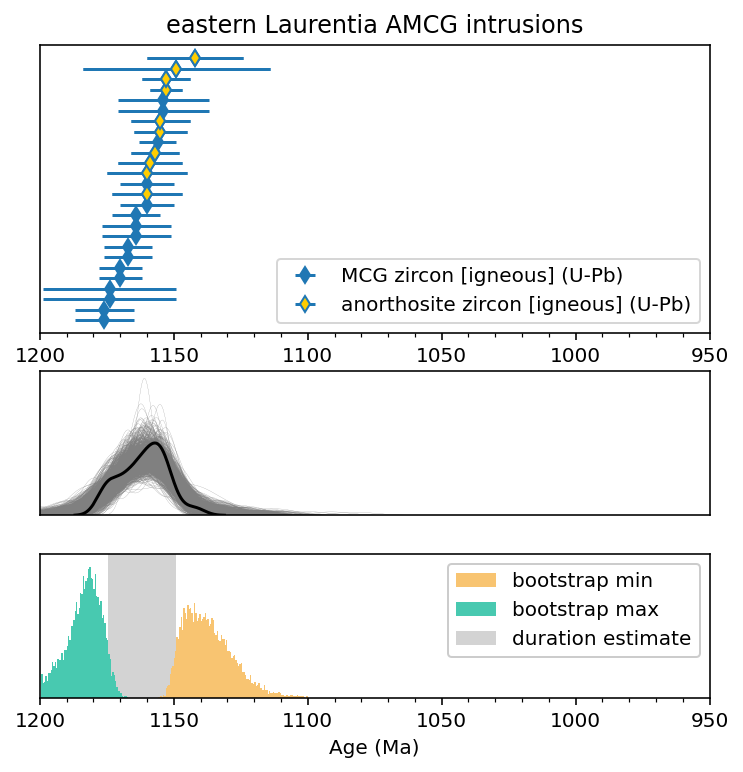

In [7]:
fig = plt.figure(figsize=(6,6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[4, 2, 2])

ax0 = fig.add_subplot(spec[0])
ax0.title.set_text('eastern Laurentia AMCG intrusions')

plt.errorbar(AMCG_dates.Age,
             AMCG_dates.index,
             xerr=AMCG_dates.Error_Plus,
             fmt='d',color='C0',label='MCG zircon [igneous] (U-Pb)')

plt.errorbar(AMCG_anorthosite.Age,
             AMCG_anorthosite.index,
             xerr=AMCG_anorthosite.Error_Plus,
             fmt='d',markeredgecolor='C0',markerfacecolor='#FFCD00',label='anorthosite zircon [igneous] (U-Pb)')

ax0.set_yticks([])

plt.legend(loc=4)
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())

ax1 = fig.add_subplot(spec[1])

boot_maxs,boot_mins,AMCG_max,AMCG_min = bootstrap_calc_plot(AMCG_dates,bootstrap_n=bootstrap_number)
AMCG_max_median = np.median(boot_maxs)
AMCG_min_median = np.median(boot_mins)

plt.xlim(1200,950)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('')
ax1.set_xlabel('')

ax2 = fig.add_subplot(spec[2])
plot_bootstrap_hist(boot_maxs,boot_mins,AMCG_max,AMCG_min)

plt.legend(framealpha=1)
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.set_yticks([])
plt.xlabel('Age (Ma)')

plt.savefig('geochron_AMCG.pdf',bbox_inches='tight',pad_inches = 0.1)
plt.savefig('geochron_AMCG.png',dpi=300,bbox_inches='tight',pad_inches = 0.1)
plt.show()

In [8]:
print(AMCG_max)
print(AMCG_min)
print('')
print(AMCG_max_median)
print(AMCG_min_median)

1174.3877307766227
1149.171977452926

1183.058537264942
1138.2774596832528


## Midcontinent crystallization dates (preceding Midcontinent Rift)

In [9]:
Abitibi_dates = dates[dates.Geological_Province == 'Midcontinent']
Abitibi_dates = Abitibi_dates.sort_values('Age',ascending=False)
Abitibi_dates.reset_index(inplace=True)

Abitibi_dates_b = Abitibi_dates[Abitibi_dates.Age_Material == 'Baddeleyite']
Abitibi_dates_perov = Abitibi_dates[Abitibi_dates.Age_Material == 'Perovskite']
Abitibi_dates_phlog = Abitibi_dates[Abitibi_dates.Age_Material == 'Phlogopite']

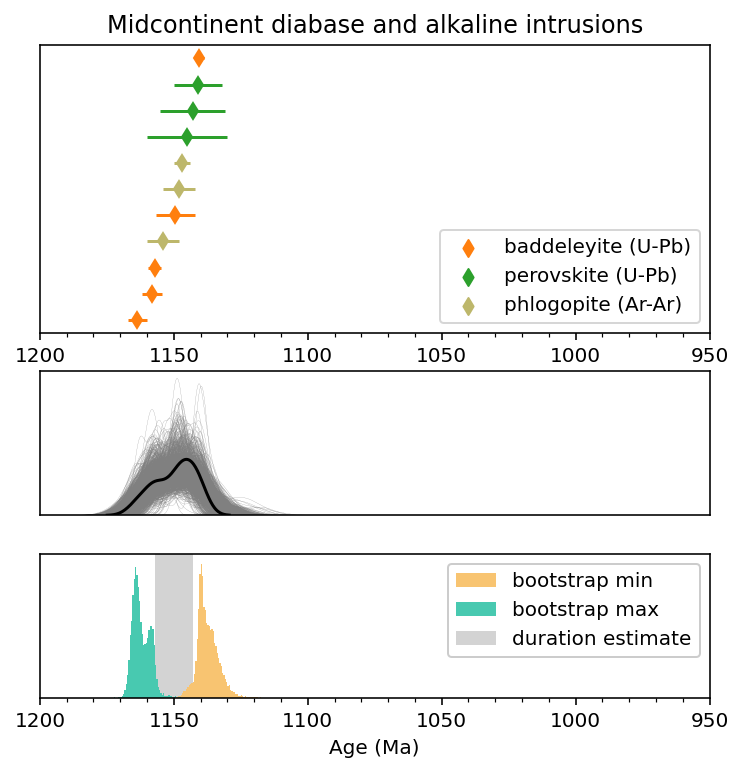

In [10]:
fig = plt.figure(figsize=(6,6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[4, 2, 2])

ax0 = fig.add_subplot(spec[0])
ax0.title.set_text('Midcontinent diabase and alkaline intrusions')

plt.errorbar(Abitibi_dates_b.Age,
             Abitibi_dates_b.index,
             xerr=Abitibi_dates_b.Error_Plus,
             fmt='d',color='C1')

plt.errorbar(Abitibi_dates_perov.Age,
             Abitibi_dates_perov.index,
             xerr=Abitibi_dates_perov.Error_Plus,
             fmt='d',color='C2')

plt.errorbar(Abitibi_dates_phlog.Age,
             Abitibi_dates_phlog.index,
             xerr=Abitibi_dates_phlog.Error_Plus,
             fmt='d',color='darkkhaki')

plt.gca().set_yticks([])
plt.legend(handles=[bad_marker,perov_marker,phlog_marker],loc=4)
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())

fig.add_subplot(spec[1])

boot_maxs,boot_mins,Abitibi_max,Abitibi_min = bootstrap_calc_plot(Abitibi_dates,bootstrap_n=bootstrap_number)
plt.xlim(1200,950)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.gca().set_xlabel('')

ax2 = fig.add_subplot(spec[2])
plot_bootstrap_hist(boot_maxs,boot_mins,Abitibi_max,Abitibi_min)

plt.legend(framealpha=1)
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.set_yticks([])
plt.xlabel('Age (Ma)')

plt.savefig('geochron_Abitibi_Alkaline.png',dpi=300,bbox_inches='tight',pad_inches = 0.1)
plt.show()

## Midcontinent Rift magmatic activity

In [11]:
MCR_dates = dates[dates.Geological_Province == 'Midcontinent Rift']
MCR_dates = MCR_dates.sort_values('Age',ascending=False)
MCR_dates.reset_index(inplace=True)

MCR_dates_b = MCR_dates[MCR_dates.Age_Material == 'Baddeleyite']
MCR_dates_z = MCR_dates[MCR_dates.Age_Material == 'Zircon']

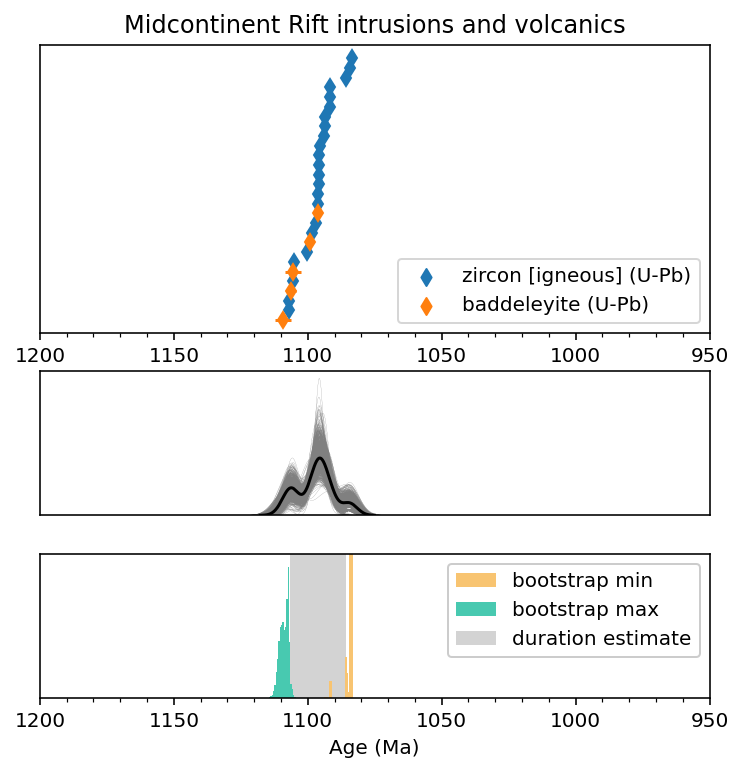

In [12]:
fig = plt.figure(figsize=(6,6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[4, 2, 2])

ax0 = fig.add_subplot(spec[0])
ax0.title.set_text('Midcontinent Rift intrusions and volcanics')

plt.errorbar(MCR_dates_z.Age,
             MCR_dates_z.index,
             xerr=MCR_dates_z.Error_Plus,
             fmt='d',color='C0')

plt.errorbar(MCR_dates_b.Age,
             MCR_dates_b.index,
             xerr=MCR_dates_b.Error_Plus,
             fmt='d',color='C1')

plt.gca().set_yticks([])
plt.legend(handles=[zircon_marker,bad_marker],loc=4)
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())

fig.add_subplot(spec[1])

boot_maxs,boot_mins,MCR_max,MCR_min = bootstrap_calc_plot(MCR_dates,bootstrap_n=bootstrap_number)
plt.xlim(1200,950)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.gca().set_xlabel('')

ax2 = fig.add_subplot(spec[2])
plot_bootstrap_hist(boot_maxs,boot_mins,MCR_max,MCR_min,age_range_max=1150,age_range_min=1050)

plt.legend(framealpha=1)
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.gca().set_ylabel('')
ax2.set_yticks([])
plt.xlabel('Age (Ma)')

plt.savefig('geochron_MCR.png',dpi=300,bbox_inches='tight',pad_inches = 0.1)
plt.show()

## Joint Midcontinent Plot


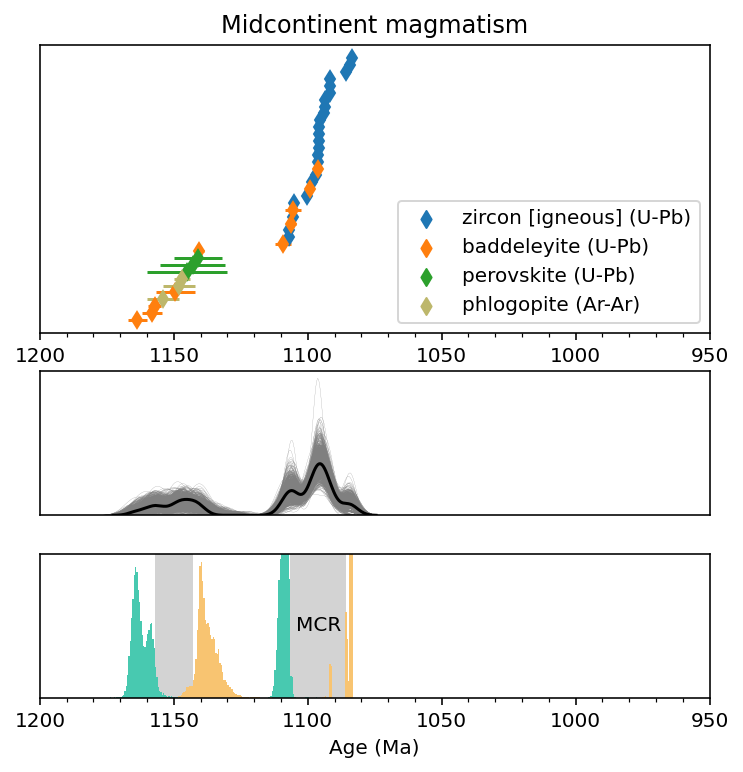

In [13]:
fig = plt.figure(figsize=(6,6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[4, 2, 2])

ax0 = fig.add_subplot(spec[0])
ax0.title.set_text('Midcontinent magmatism')

plt.errorbar(Abitibi_dates_b.Age,
             Abitibi_dates_b.index,
             xerr=Abitibi_dates_b.Error_Plus,
             fmt='d',color='C1')

plt.errorbar(Abitibi_dates_perov.Age,
             Abitibi_dates_perov.index,
             xerr=Abitibi_dates_perov.Error_Plus,
             fmt='d',color='C2')

plt.errorbar(Abitibi_dates_phlog.Age,
             Abitibi_dates_phlog.index,
             xerr=Abitibi_dates_phlog.Error_Plus,
             fmt='d',color='darkkhaki')

plt.errorbar(MCR_dates_z.Age,
             MCR_dates_z.index+len(Abitibi_dates),
             xerr=MCR_dates_z.Error_Plus,
             fmt='d',color='C0')

plt.errorbar(MCR_dates_b.Age,
             MCR_dates_b.index+len(Abitibi_dates),
             xerr=MCR_dates_b.Error_Plus,
             fmt='d',color='C1')

plt.gca().set_yticks([])
#plt.gca().set_xticks([])
plt.legend(handles=[zircon_marker,bad_marker,perov_marker,phlog_marker],loc=4)
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())

fig.add_subplot(spec[1])

boot_maxs,boot_mins,Midcontinent_max,Midcontinent_max = bootstrap_calc_plot(pd.concat([Abitibi_dates,MCR_dates]),
                                                                            kde_bandwidth=0.25,bootstrap_n=bootstrap_number)
plt.xlim(1200,950)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.gca().set_xlabel('')

ax2 = fig.add_subplot(spec[2])

boot_maxs,boot_mins,MCR_max,MCR_min = bootstrap_calc_plot(MCR_dates,bootstrap_n=bootstrap_number,plot=False)
plot_bootstrap_hist(boot_maxs,boot_mins,MCR_max,MCR_min,age_range_max=1150,age_range_min=1050)

MCR_max_median = np.median(boot_maxs)
MCR_min_median = np.median(boot_mins)

boot_maxs,boot_mins,Abitibi_max,Abitibi_min = bootstrap_calc_plot(Abitibi_dates,bootstrap_n=bootstrap_number,plot=False)
plot_bootstrap_hist(boot_maxs,boot_mins,Abitibi_max,Abitibi_min)

Abitibi_max_median = np.median(boot_maxs)
Abitibi_min_median = np.median(boot_mins)

plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.set_yticks([])
plt.xlabel('Age (Ma)')

y_text = plt.gca().get_ylim()[1]*0.5
plt.text(1096,y_text,'MCR',horizontalalignment='center',verticalalignment='center')

plt.savefig('geochron_Midcontinent.pdf',bbox_inches='tight',pad_inches = 0.1)
plt.savefig('geochron_Midcontinent.png',dpi=300,bbox_inches='tight',pad_inches = 0.1)
plt.show()

In [14]:
print(Abitibi_max)
print(Abitibi_min)
print('')
print(Abitibi_max_median)
print(Abitibi_min_median)
print('')
print(MCR_max)
print(MCR_min)
print('')
print(MCR_max_median)
print(MCR_min_median)

1156.9048083063449
1142.8499555746337

1162.8477401540333
1138.2300727263219

1106.7528875949572
1085.6889374757304

1108.6284523955337
1083.5724985762859


## Blue Ridge metamorphism dates

Metamorphic dates from the Blue Ridge are compiled using the same headers as the GSC Knowledgebase

In [15]:
Blue_Ridge_dates = dates[(dates.Geological_Province == 'Blue Ridge') & (dates.Age_Material != 'Titanite')]
Blue_Ridge_dates = Blue_Ridge_dates.sort_values('Age',ascending=False)
Blue_Ridge_dates.reset_index(inplace=True)
Blue_Ridge_dates.tail(1)

,index,Sample_No,Age,Error_Plus,Error_Minus,Age_Method,Age_Interpretation,Age_Note,Age_Material,Age_Technique,...,Rock_Type,Rock_Description,References,Compilation_Source,Unnamed: 20,UTM_Zone,UTM_Easting,UTM_Northing,Comment,Tectonic_Unit
49,683,MR-11-193,984.0,17.0,17.0,Pb/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,...,Metamorphic,Ylbg lineated biotite meta-granite,NaN,compiled by NSH,Tollo2017a,17,472624.0,4048678.0,NaN,NaN


In [16]:
Blue_Ridge_dates_Shaw = Blue_Ridge_dates[Blue_Ridge_dates.Age>1120]
Blue_Ridge_dates_Gren = Blue_Ridge_dates[Blue_Ridge_dates.Age<1120]

In [17]:
Blue_Ridge_dates_z = Blue_Ridge_dates[Blue_Ridge_dates.Age_Material == 'Zircon']
#Blue_Ridge_dates_t = Blue_Ridge_dates[Blue_Ridge_dates.Age_Material == 'Titanite']
Blue_Ridge_dates_g = Blue_Ridge_dates[Blue_Ridge_dates.Age_Material == 'Garnet']
Blue_Ridge_dates_m = Blue_Ridge_dates[Blue_Ridge_dates.Age_Material == 'Monazite']

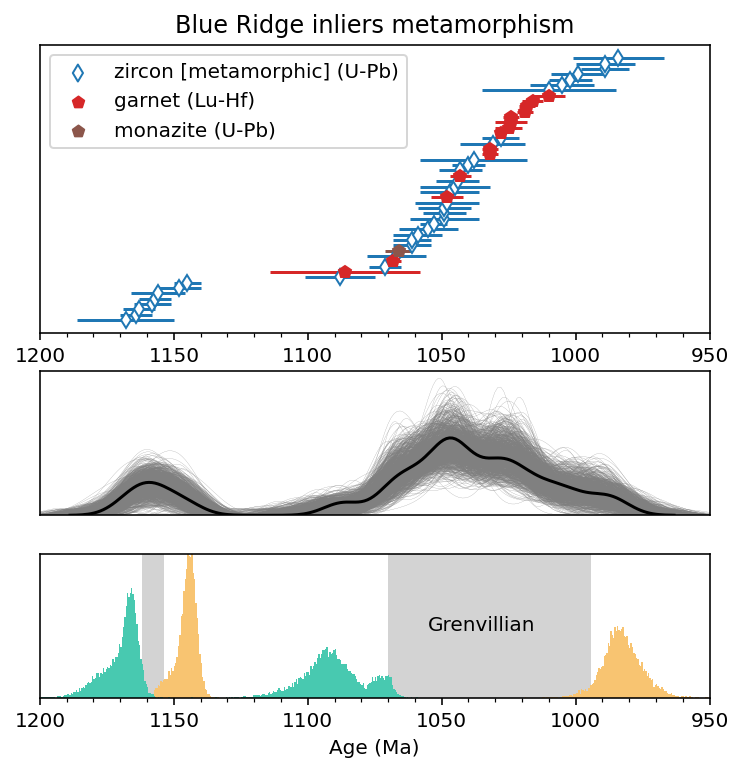

In [18]:
fig = plt.figure(figsize=(6,6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[4, 2, 2])


ax0 = fig.add_subplot(spec[0])
ax0.title.set_text('Blue Ridge inliers metamorphism')

plt.errorbar(Blue_Ridge_dates_z.Age,
             Blue_Ridge_dates_z.index,
             xerr=Blue_Ridge_dates_z.Error_Plus,
             fmt='d',color='C0',mfc='white',label='zircon rims')

# plt.errorbar(Blue_Ridge_dates_t.Age,
#              Blue_Ridge_dates_t.index,
#              xerr=Blue_Ridge_dates_t.Error_Plus,
#              fmt='^',color='C1',label='titanite')

plt.errorbar(Blue_Ridge_dates_g.Age,
             Blue_Ridge_dates_g.index,
             xerr=Blue_Ridge_dates_g.Error_Plus,
             fmt='p',color='C3',label='garnet (Lu-Hf)')

plt.errorbar(Blue_Ridge_dates_m.Age,
             Blue_Ridge_dates_m.index,
             xerr=Blue_Ridge_dates_m.Error_Plus,
             fmt='p',color='C5',label='monazite')

plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.gca().set_yticks([])
plt.legend(handles=[zircon_rim_marker,garnet_marker,monazite_marker],loc=2)

fig.add_subplot(spec[1])
boot_maxs,boot_mins,Blue_Ridge_max,Blue_Ridge_min = bootstrap_calc_plot(Blue_Ridge_dates,bootstrap_n=bootstrap_number,kde_bandwidth=0.3)

plt.xlim(1200,950)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.gca().set_xlabel('')

fig.add_subplot(spec[2])
boot_maxs,boot_mins,Blue_Ridge_Shaw_max,Blue_Ridge_Shaw_min = bootstrap_calc_plot(Blue_Ridge_dates_Shaw,bootstrap_n=bootstrap_number,
                                                                                  kde_bandwidth=0.8,plot=False)
plot_bootstrap_hist(boot_maxs,boot_mins,Blue_Ridge_Shaw_max,Blue_Ridge_Shaw_min,age_range_max=1200,age_range_min=950)

Blue_Ridge_Shaw_max_median = np.median(boot_maxs)
Blue_Ridge_Shaw_min_median = np.median(boot_mins)

boot_maxs,boot_mins,Blue_Ridge_Gren_max,Blue_Ridge_Gren_min = bootstrap_calc_plot(Blue_Ridge_dates_Gren,bootstrap_n=bootstrap_number,
                                                                                  kde_bandwidth=0.8,plot=False)
plot_bootstrap_hist(boot_maxs,boot_mins,Blue_Ridge_Gren_max,Blue_Ridge_Gren_min,age_range_max=1200,age_range_min=950,ylim='hist_min')

Blue_Ridge_Gren_max_median = np.median(boot_maxs)
Blue_Ridge_Gren_min_median = np.median(boot_mins)

#plt.legend(framealpha=1,bbox_to_anchor=(1.4,1))
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.xlabel('Age (Ma)')

y_text = plt.gca().get_ylim()[1]*0.5
plt.text(1035,y_text,'Grenvillian',horizontalalignment='center',verticalalignment='center')

plt.savefig('geochron_Blue_Ridge.pdf',bbox_inches='tight',pad_inches = 0.1)
plt.savefig('geochron_Blue_Ridge.png',dpi=300,bbox_inches='tight',pad_inches = 0.1)
plt.show()

In [19]:
print(Blue_Ridge_Shaw_max)
print(Blue_Ridge_Shaw_min)
print('')
print(Blue_Ridge_Shaw_max_median)
print(Blue_Ridge_Shaw_min_median)
print('')
print(Blue_Ridge_Gren_max)
print(Blue_Ridge_Gren_min)
print('')
print(Blue_Ridge_Gren_max_median)
print(Blue_Ridge_Gren_min_median)

1161.8784826270157
1153.5745266989106

1167.840579532575
1144.683823463181

1069.9811878420742
994.2137780864057

1090.8238923086892
982.9152927469515


## Grenville metamorphism

In [20]:
Grenville_Province_dates = dates[dates.Geological_Province == 'Grenville Province']
Grenville_Province_dates = Grenville_Province_dates.sort_values('Age',ascending=False)
Grenville_Province_dates = Grenville_Province_dates[Grenville_Province_dates['Age'] < 1250]
Grenville_Province_dates = Grenville_Province_dates[Grenville_Province_dates['Error_Plus'] < 40]
Grenville_Province_dates = Grenville_Province_dates[Grenville_Province_dates['Error_Plus'] != 0]
Grenville_Province_dates = Grenville_Province_dates[Grenville_Province_dates['Age_Qualifier'] != 'Unverified']

In [21]:
Adirondack_dates_meta = dates[(dates.Geological_Province == 'Adirondacks') & (dates.Age_Interpretation == 'Metamorphic')]
Adirondack_dates_meta

,Sample_No,Age,Error_Plus,Error_Minus,Age_Method,Age_Interpretation,Age_Note,Age_Material,Age_Technique,Age_Qualifier,...,Rock_Type,Rock_Description,References,Compilation_Source,Unnamed: 20,UTM_Zone,UTM_Easting,UTM_Northing,Comment,Tectonic_Unit
795,AM87-10,1049.0,4.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,NaN,...,Plutonic,Minerva charnockite,NaN,compiled by NSH,Hamilton2004a,NaN,NaN,NaN,NaN,NaN
797,AM86-8,1031.0,30.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,NaN,...,Plutonic,Snowy Mountain mangerite,NaN,compiled by NSH,Hamilton2004a,NaN,NaN,NaN,NaN,NaN
799,AM87-9,1041.0,6.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,NaN,...,Plutonic,Gore Mountain charnockite,NaN,compiled by NSH,Hamilton2004a,NaN,NaN,NaN,NaN,NaN
801,AM87-8,1048.0,10.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,NaN,...,Plutonic,Oregon Dome ferrodiorite interpretted to be co...,NaN,compiled by NSH,Hamilton2004a,NaN,NaN,NaN,NaN,NaN
824,AM-87-10,1049.0,4.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,NaN,...,Plutonic,Minerva charnockite,NaN,compiled by NSH,McLelland2004a,NaN,NaN,NaN,NaN,NaN
826,cm,1042.0,4.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,NaN,...,Metamorphic,diopside-bearing quartzite with metamorphic zi...,NaN,compiled by NSH,Chiarenzelli2011b,NaN,NaN,NaN,NaN,NaN
827,cm,1073.0,15.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,NaN,...,Metamorphic,diopside-bearing quartzite with metamorphic zi...,NaN,compiled by NSH,Chiarenzelli2011b,NaN,NaN,NaN,NaN,NaN
828,16TG-150,1160.0,7.0,NaN,U/Pb,Metamorphic,U-Th-Total Pb; weighted mean of 17,Monazite,Microprobe,NaN,...,Metamorphic,garnet-rich gray migmatitic gneiss with leucos...,Williams2019a,compiled by NSH,Williams2019a,18,616209.0,4845203.0,NaN,NaN
829,16TG-150,1030.0,8.0,NaN,U/Pb,Metamorphic,U-Th-Total Pb; weighted mean of 7,Monazite,Microprobe,NaN,...,Metamorphic,garnet-rich gray migmatitic gneiss with leucos...,Williams2019a,compiled by NSH,Williams2019a,18,616209.0,4845203.0,NaN,NaN
830,16TG-151,1165.0,5.0,NaN,U/Pb,Metamorphic,U-Th-Total Pb; weighted mean of 21,Monazite,Microprobe,NaN,...,Metamorphic,garnet-rich gray migmatitic gneiss with leucos...,Williams2019a,compiled by NSH,Williams2019a,18,612109.0,4843661.0,NaN,NaN


In [22]:
Grenville_dates_t = Grenville_Province_dates[(Grenville_Province_dates.Age_Material == 'titanite')|(Grenville_Province_dates.Age_Material == 'Titanite')]

Grenville_dates_m = Grenville_Province_dates[(Grenville_Province_dates.Age_Material == 'Monazite')]
Grenville_dates_z = Grenville_Province_dates[(Grenville_Province_dates.Age_Material == 'Zircon')
                                             &(Grenville_Province_dates.Age_Technique != 'TIMS')]

Grenville_dates_m_z = pd.concat([Grenville_dates_m,Grenville_dates_z,Adirondack_dates_meta])
Grenville_dates_m_z = Grenville_dates_m_z.sort_values('Age',ascending=False)
Grenville_dates_m_z.reset_index(inplace=True)
Grenville_dates_m =  Grenville_dates_m_z[(Grenville_dates_m_z.Age_Material == 'Monazite')]
Grenville_dates_z =  Grenville_dates_m_z[(Grenville_dates_m_z.Age_Material == 'Zircon')]

In [23]:
Grenville_dates_m_z_Gren = Grenville_dates_m_z[Grenville_dates_m_z.Age < 1100 ]
Grenville_dates_m_z_Shaw = Grenville_dates_m_z[Grenville_dates_m_z.Age > 1140]

In [24]:
Grenville_dates_m_z_Gren.head(50)

,index,Sample_No,Age,Error_Plus,Error_Minus,Age_Method,Age_Interpretation,Age_Note,Age_Material,Age_Technique,...,Rock_Type,Rock_Description,References,Compilation_Source,Unnamed: 20,UTM_Zone,UTM_Easting,UTM_Northing,Comment,Tectonic_Unit
21,860,11AM-20,1092.0,7.0,NaN,U/Pb,Metamorphic,U-Th-Total Pb,Monazite,Microprobe,...,Metamorphic,garnet– biotite gneiss,Markley2018,compiled by NSH,Markley2018a,NaN,NaN,NaN,NaN,NaN
22,182,90 NKD 35E,1092.0,1.0,1.0,U/Pb,Peak Metamorphic,"2 fractions (1 abr), concordant and v. near co...",Monazite,TIMS,...,Sedimentary,Coarse-grained garnet-tourmal-sill peral leuco...,"Corrigan, D. and van Breemen, O., 1997. U-Pb a...",GSCdatabase,NaN,NaN,NaN,NaN,NaN,NaN
23,864,11AM-1,1088.2,12.4,NaN,U/Pb,Metamorphic,U-Th-Total Pb,Monazite,Microprobe,...,Metamorphic,garnet– biotite gneiss,Markley2018,compiled by NSH,Markley2018a,NaN,NaN,NaN,NaN,NaN
24,169,7 Henrietta Isl,1088.0,3.0,3.0,U/Pb,Metamorphic,"4 fractions (lightly abr), concordant, fall in...",Monazite,TIMS,...,Metamorphic,metapelite: grt-bt-ky-sil-Kfs-pl-qtz-rt assemb...,"Corrigan, D., Rivers, T. and Dunning, G., 2000...",GSCdatabase,NaN,NaN,NaN,NaN,NaN,NaN
25,862,HA13,1085.9,7.2,NaN,U/Pb,Metamorphic,U-Th-Total Pb,Monazite,Microprobe,...,Metamorphic,garnet– biotite gneiss,Markley2018,compiled by NSH,Markley2018a,NaN,NaN,NaN,NaN,NaN
26,186,DS-S99,1077.0,3.0,3.0,U/Pb,Peak Metamorphic,"2 fractions, near-concordant and overlapping. ...",Monazite,TIMS,...,Metamorphic,polydeformed granodioritic gneiss,"Scott, D.J., Machado, N., Hanmer, S. and Garie...",GSCdatabase,NaN,NaN,NaN,NaN,NaN,NaN
27,227,AG-99-1311A,1076.0,4.0,4.0,U/Pb,Metamorphic,weighted mean age of three monazite analyse; 0...,Monazite,TIMS,...,Metamorphic,les paragneiss de Biotite-sillimanite-grenat o...,"Wodicka, N., David, J., Parent, M., Gobeil, A....",GSCdatabase,NaN,NaN,NaN,NaN,NaN,NaN
28,536,2S0207-2,1074.0,7.0,7.0,U/Pb,Metamorphic,"Low-U (metamorphic) zircons, 7 spots from 7 gr...",Zircon,SHRIMP,...,Plutonic,Pegmatitic diatexite,"Slagstad, T., Hamilton, M.A., Jamieson, R.A. a...",GSCdatabase,NaN,NaN,NaN,NaN,NaN,NaN
29,198,SSA-12,1074.0,2.0,2.0,U/Pb,Metamorphic,"Single concordant fraction, age is 207Pb/206Pb...",Monazite,TIMS,...,Metamorphic,gneiss,"Cosca, M.A., Sutter, J.F. and Essene, E.J., 19...",GSCdatabase,NaN,NaN,NaN,NaN,NaN,NaN
30,827,cm,1073.0,15.0,NaN,U/Pb,Metamorphic,76 weighted mean,Zircon,SHRIMP,...,Metamorphic,diopside-bearing quartzite with metamorphic zi...,NaN,compiled by NSH,Chiarenzelli2011b,NaN,NaN,NaN,NaN,NaN


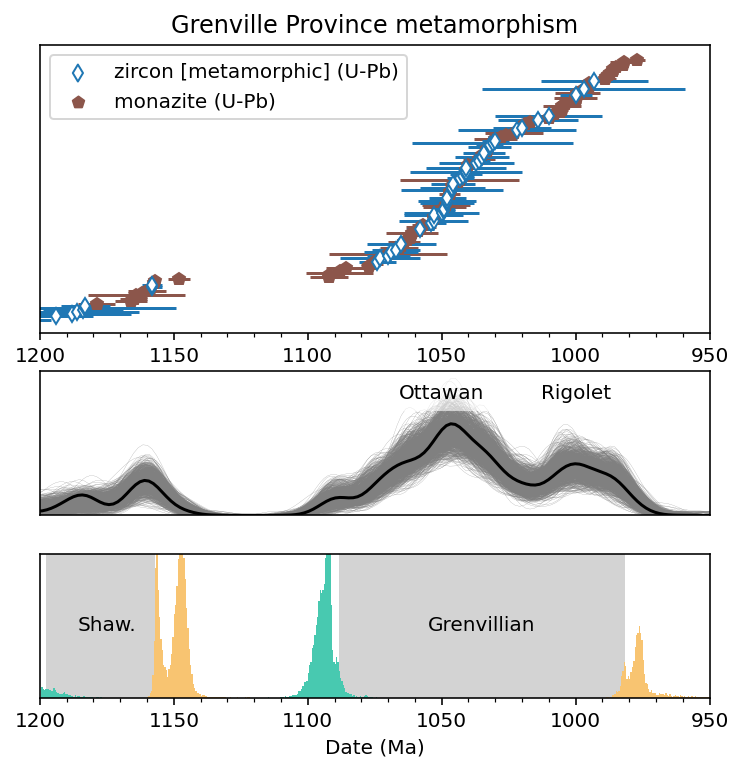

In [25]:
fig = plt.figure(figsize=(6,6))
spec = gridspec.GridSpec(ncols=1, nrows=3,
                         height_ratios=[4, 2, 2])

ax0 = fig.add_subplot(spec[0])
ax0.title.set_text('Grenville Province metamorphism')

# plt.errorbar(Grenville_dates_t.Age,
#              Grenville_dates_t.index,
#              xerr=Grenville_dates_t.Error_Plus,
#              fmt='^',color='C1',label='titanite')

plt.errorbar(Grenville_dates_m.Age,
             Grenville_dates_m.index,
             xerr=Grenville_dates_m.Error_Plus,
             fmt='p',color='C5',label='monazite')

plt.errorbar(Grenville_dates_z.Age,
             Grenville_dates_z.index,
             xerr=Grenville_dates_z.Error_Plus,
             fmt='d',color='C0',mfc='white',label='zircon rims')


plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.gca().set_yticks([])

plt.legend(handles=[zircon_rim_marker,monazite_marker],loc=2)

fig.add_subplot(spec[1])

boot_maxs,boot_mins,Grenville_max,Grenville_min = bootstrap_calc_plot(Grenville_dates_m_z,bootstrap_n=bootstrap_number,kde_bandwidth=0.25)


plt.xlim(1200,950)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.gca().set_xlabel('')


y_text = plt.gca().get_ylim()[1]*0.85
t = plt.text(1050,y_text,'Ottawan',backgroundcolor='white',horizontalalignment='center',verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none'))
t = plt.text(1000,y_text,'Rigolet',horizontalalignment='center',verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none'))

fig.add_subplot(spec[2])
boot_maxs,boot_mins,Grenville_Shaw_max,Grenville_Shaw_min = bootstrap_calc_plot(Grenville_dates_m_z_Shaw,
                                                                                bootstrap_n=bootstrap_number,kde_bandwidth=0.8,plot=False)
Grenville_Shaw_max_median = np.median(boot_maxs)
Grenville_Shaw_min_median = np.median(boot_mins)
plot_bootstrap_hist(boot_maxs,boot_mins,Grenville_Shaw_max,Grenville_Shaw_min,age_range_max=1200,age_range_min=950)

boot_maxs,boot_mins,Grenville_Gren_max,Grenville_Gren_min = bootstrap_calc_plot(Grenville_dates_m_z_Gren,
                                                                                bootstrap_n=bootstrap_number,kde_bandwidth=0.8,plot=False)
Grenville_Gren_max_median = np.median(boot_maxs)
Grenville_Gren_min_median = np.median(boot_mins)
plot_bootstrap_hist(boot_maxs,boot_mins,Grenville_Gren_max,Grenville_Gren_min,age_range_max=1200,age_range_min=950,ylim='hist_min')

plt.xlim(1200,950)
plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.xlabel('Date (Ma)')
plt.gca().set_yticks([])
plt.gca().set_ylabel('')

y_text = plt.gca().get_ylim()[1]*0.5
plt.text(1035,y_text,'Grenvillian',horizontalalignment='center',verticalalignment='center')
plt.text(1175,y_text,'Shaw.',horizontalalignment='center',verticalalignment='center')

plt.savefig('geochron_Grenville.pdf',bbox_inches='tight',pad_inches = 0.1)
plt.savefig('geochron_Grenville.png',dpi=300,bbox_inches='tight',pad_inches = 0.1)
plt.show()

In [26]:
print(Grenville_Shaw_max)
print(Grenville_Shaw_min)
print('')
print(Grenville_Shaw_max_median)
print(Grenville_Shaw_min_median)
print('')
print(Grenville_Gren_max)
print(Grenville_Gren_min)
print('')
print(Grenville_Gren_max_median)
print(Grenville_Gren_min_median)

1197.8893694380222
1156.8838488628703

1212.3191969162885
1148.564132672786

1088.4528472656139
981.5636906706234

1092.9402778283145
916.4971085848133


In [27]:
import matplotlib.image as mpimg

geochron_Grenville_img = mpimg.imread('geochron_Grenville.png')
geochron_Blue_Ridge_img = mpimg.imread('geochron_Blue_Ridge.png')
geochron_AMCG_img = mpimg.imread('geochron_AMCG.png')
geochron_Abitibi_img = mpimg.imread('geochron_Abitibi_Alkaline.png')
geochron_MCR_img = mpimg.imread('geochron_MCR.png')
geochron_Midcontinent_img = mpimg.imread('geochron_Midcontinent.png')

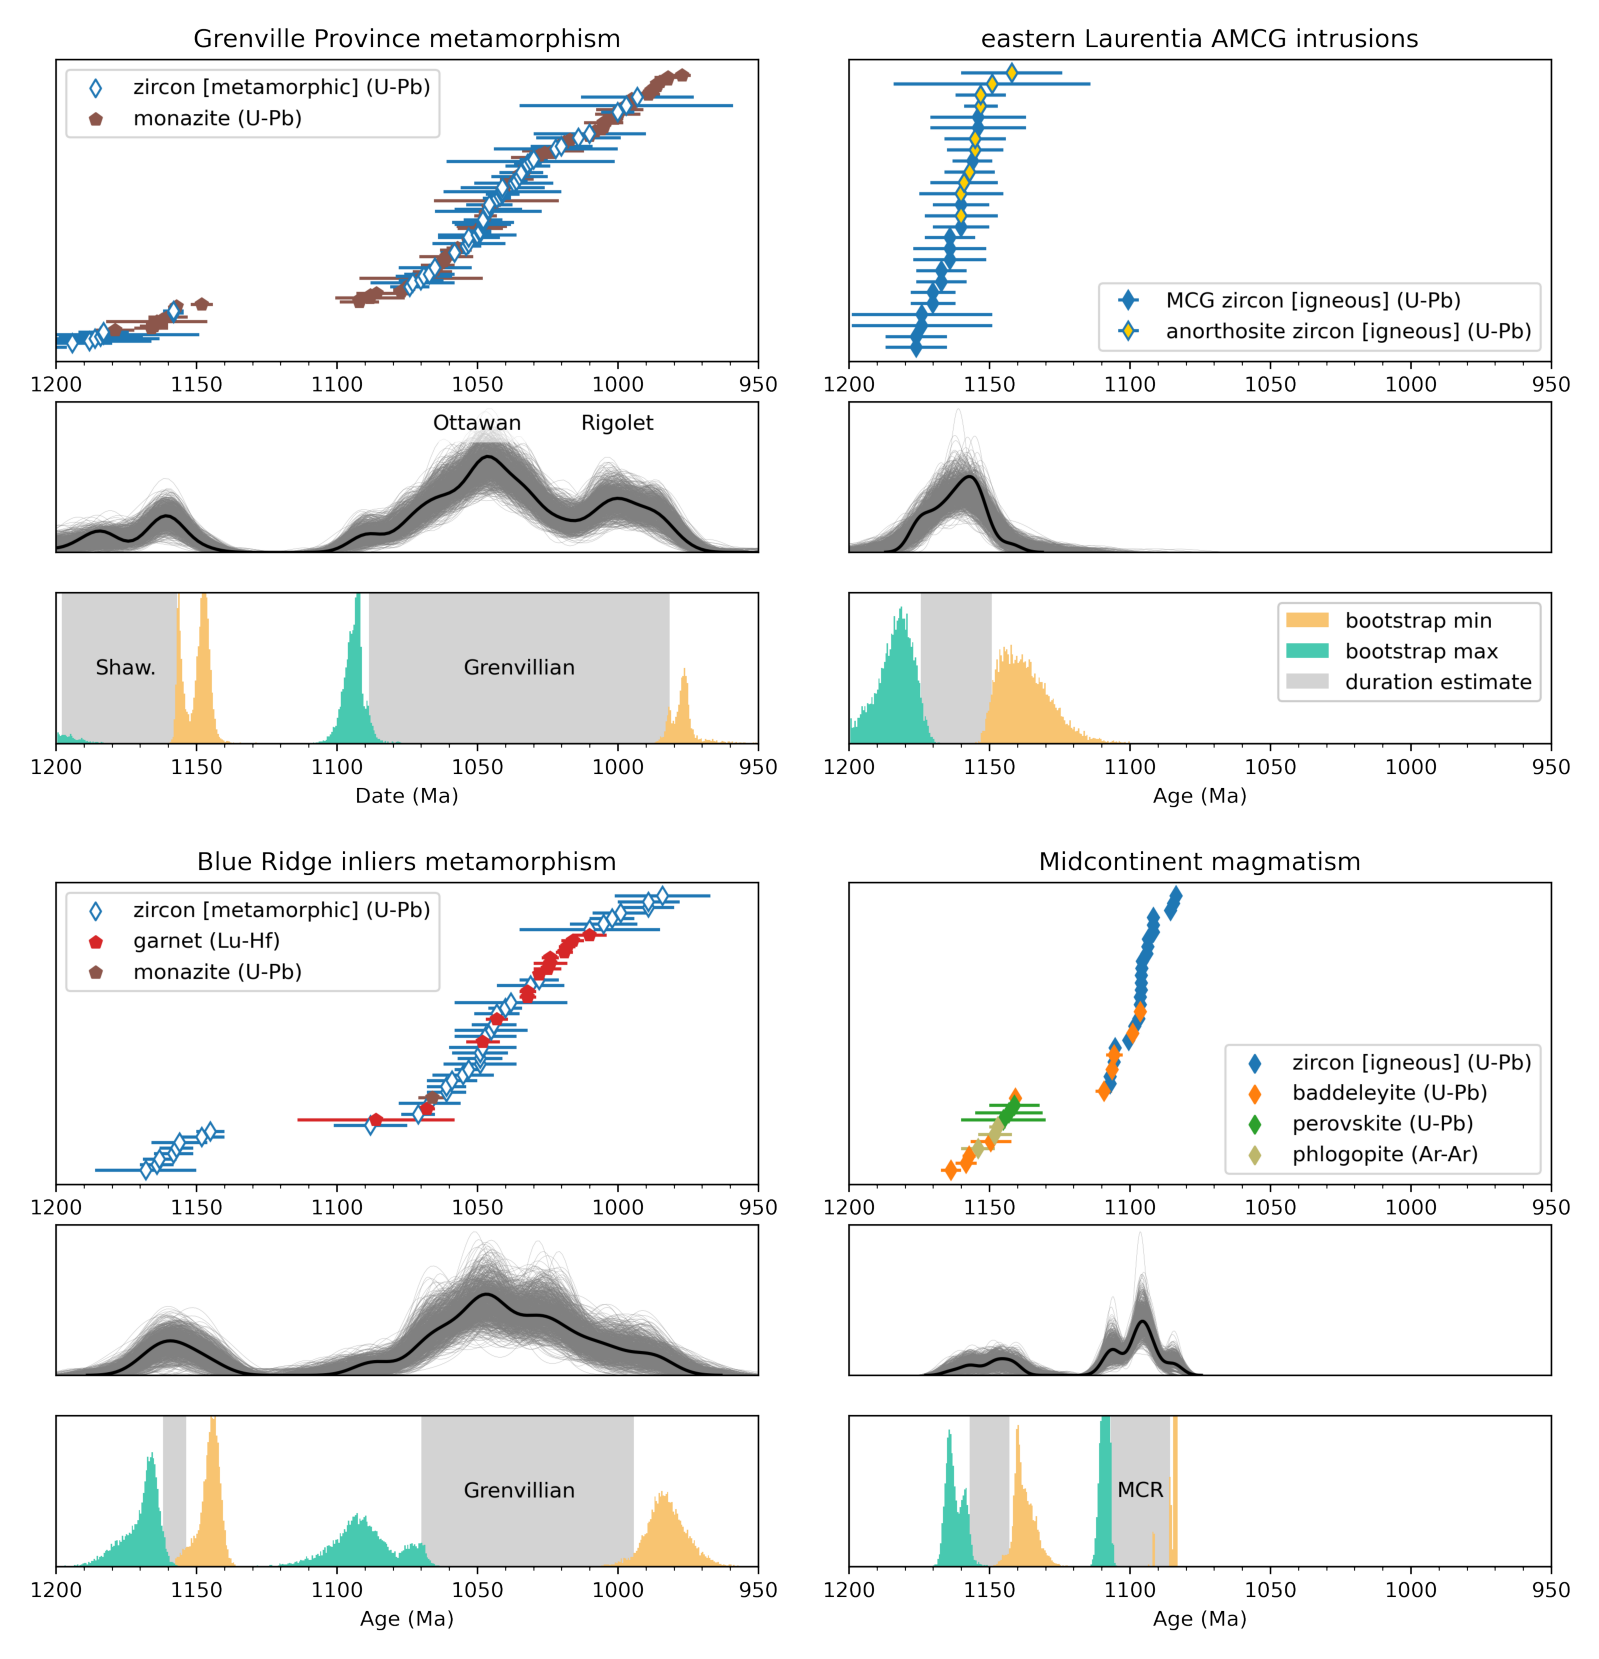

In [28]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [geochron_Grenville_img,
                         geochron_AMCG_img,
                         geochron_Blue_Ridge_img,
                         geochron_Midcontinent_img]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")


plt.subplots_adjust(wspace=-5, hspace=-5)

plt.savefig('geochron_figure.png',dpi=300)

plt.show()

## Summary timelines

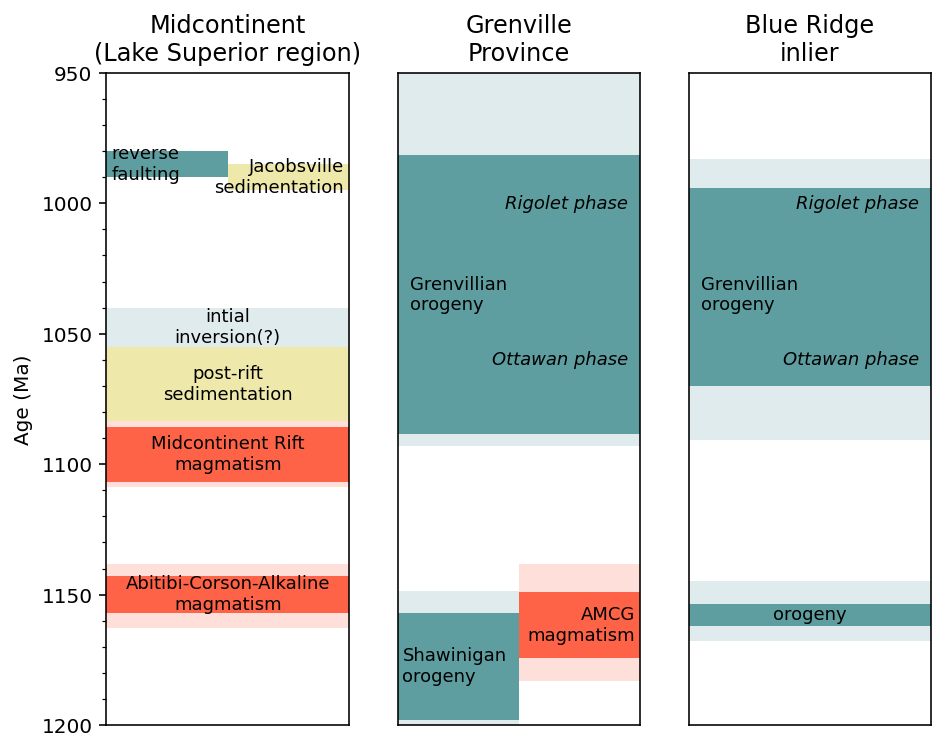

In [32]:
fig = plt.figure(figsize=(10,6))
spec = gridspec.GridSpec(ncols=4, nrows=1,
                         width_ratios=[1, 1, 1, 1])

ax0 = fig.add_subplot(spec[0])
ax0.title.set_text('Midcontinent\n(Lake Superior region)')

Abitibi_median_rect = matplotlib.patches.Rectangle((-1, Abitibi_max_median),2, Abitibi_min_median-Abitibi_max_median, facecolor='tomato',edgecolor='none', alpha=0.2)
ax0.add_patch(Abitibi_median_rect)
Abitibi_rect = matplotlib.patches.Rectangle((-1, Abitibi_max),2, Abitibi_min-Abitibi_max, facecolor='tomato',edgecolor='none',)
ax0.add_patch(Abitibi_rect)
plt.text(0.5,(Abitibi_max+Abitibi_min)/2,'Abitibi-Corson-Alkaline\nmagmatism',horizontalalignment='center',verticalalignment='center',fontsize=9)

MCR_median_rect = matplotlib.patches.Rectangle((-1, MCR_max_median),2, MCR_min_median-MCR_max_median, facecolor='tomato', edgecolor='none', alpha=0.2)
ax0.add_patch(MCR_median_rect)
MCR_rect = matplotlib.patches.Rectangle((-1, MCR_max),2, MCR_min-MCR_max, facecolor='tomato', edgecolor='none')
ax0.add_patch(MCR_rect)
plt.text(0.5,(MCR_max+MCR_min)/2,'Midcontinent Rift\nmagmatism',horizontalalignment='center',verticalalignment='center',fontsize=9)

Oronto_rect = matplotlib.patches.Rectangle((0, 1055),1, MCR_min_median-1055, facecolor='palegoldenrod', edgecolor='none')
ax0.add_patch(Oronto_rect)
plt.text(0.5,(MCR_min_median+1055)/2,'post-rift\nsedimentation',horizontalalignment='center',verticalalignment='center',fontsize=9)

Montreal_River_rect = matplotlib.patches.Rectangle((0, 1040),1, 15,facecolor='cadetblue',edgecolor='none', alpha=0.2)
ax0.add_patch(Montreal_River_rect)
plt.text(0.5,(1040+1055)/2,'intial\ninversion(?)',horizontalalignment='center',verticalalignment='center',fontsize=9)

Kewee_Fault_rect = matplotlib.patches.Rectangle((0, 980),0.5, 10, facecolor='cadetblue',edgecolor='none',)
ax0.add_patch(Kewee_Fault_rect)
plt.text(0.02,985,'reverse\nfaulting',horizontalalignment='left',verticalalignment='center',fontsize=9)

Jacobsville_rect = matplotlib.patches.Rectangle((0.5, 985),0.5, 10, facecolor='palegoldenrod',edgecolor='none',)
ax0.add_patch(Jacobsville_rect)
plt.text(0.98,990,'Jacobsville\nsedimentation',horizontalalignment='right',verticalalignment='center',fontsize=9)

plt.ylim(1200,950)
plt.gca().set_xticks([])
plt.gca().yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.ylabel('Age (Ma)')

ax1 = fig.add_subplot(spec[1])
ax1.title.set_text('Grenville\nProvince')

ACMG_median_rect = matplotlib.patches.Rectangle((0.5, AMCG_max_median),2, AMCG_min_median-AMCG_max_median, facecolor='tomato',edgecolor='none', alpha=0.2)
ax1.add_patch(ACMG_median_rect)
ACMG_rect = matplotlib.patches.Rectangle((0.5, AMCG_max),2, AMCG_min-AMCG_max, facecolor='tomato',edgecolor='none')
ax1.add_patch(ACMG_rect)
plt.text(0.98,(AMCG_max+AMCG_min)/2,'AMCG\nmagmatism',horizontalalignment='right',verticalalignment='center',fontsize=9)

Grenville_Shaw_median_rect = matplotlib.patches.Rectangle((0, Grenville_Shaw_max_median),0.5, Grenville_Shaw_min_median-Grenville_Shaw_max_median, facecolor='cadetblue',edgecolor='none', alpha=0.2)
ax1.add_patch(Grenville_Shaw_median_rect)
Grenville_Shaw_rect = matplotlib.patches.Rectangle((0, Grenville_Shaw_max),0.5, Grenville_Shaw_min-Grenville_Shaw_max, facecolor='cadetblue',edgecolor='none')
ax1.add_patch(Grenville_Shaw_rect)
plt.text(0.02,(Grenville_Shaw_max+Grenville_Shaw_min)/2,'Shawinigan\norogeny',horizontalalignment='left',verticalalignment='center',fontsize=9)

Grenville_Grenville_median_rect = matplotlib.patches.Rectangle((-1, Grenville_Gren_max_median),2, Grenville_Gren_min_median-Grenville_Gren_max_median, facecolor='cadetblue',edgecolor='none', alpha=0.2)
ax1.add_patch(Grenville_Grenville_median_rect)
Grenville_Grenville_rect = matplotlib.patches.Rectangle((-1, Grenville_Gren_max),2, Grenville_Gren_min-Grenville_Gren_max, facecolor='cadetblue',edgecolor='none')
ax1.add_patch(Grenville_Grenville_rect)
plt.text(0.05,(Grenville_Gren_max+Grenville_Gren_min)/2,'Grenvillian\norogeny',horizontalalignment='left',verticalalignment='center',fontsize=9)
plt.text(0.95,1060,'Ottawan phase',horizontalalignment='right',verticalalignment='center',style='italic',fontsize=9)
plt.text(0.95,1000,'Rigolet phase',horizontalalignment='right',verticalalignment='center',style='italic',fontsize=9)

plt.ylim(1200,950)
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.gca().set_xticks([])

ax2 = fig.add_subplot(spec[2])
ax2.title.set_text('Blue Ridge\ninlier')

Blue_Ridge_Shaw_median_rect = matplotlib.patches.Rectangle((-1, Blue_Ridge_Shaw_max_median),2, Blue_Ridge_Shaw_min_median-Blue_Ridge_Shaw_max_median,
                                                           facecolor='cadetblue',edgecolor='none', alpha=0.2)
ax2.add_patch(Blue_Ridge_Shaw_median_rect)

Blue_Ridge_Shaw_rect = matplotlib.patches.Rectangle((-1, Blue_Ridge_Shaw_max),2, Blue_Ridge_Shaw_min-Blue_Ridge_Shaw_max,facecolor='cadetblue',edgecolor='none')
ax2.add_patch(Blue_Ridge_Shaw_rect)
plt.text(0.5,(Blue_Ridge_Shaw_max+Blue_Ridge_Shaw_min)/2,'orogeny',horizontalalignment='center',verticalalignment='center',fontsize=9)



Blue_Ridge_Grenville_median_rect = matplotlib.patches.Rectangle((-1, Blue_Ridge_Gren_max_median),2, Blue_Ridge_Gren_min_median-Blue_Ridge_Gren_max_median,
                                                                facecolor='cadetblue',edgecolor='none', alpha=0.2)
ax2.add_patch(Blue_Ridge_Grenville_median_rect)

Blue_Ridge_Grenville_rect = matplotlib.patches.Rectangle((-1, Blue_Ridge_Gren_max),2, Blue_Ridge_Gren_min-Blue_Ridge_Gren_max, facecolor='cadetblue',edgecolor='none')
ax2.add_patch(Blue_Ridge_Grenville_rect)

plt.text(0.05,(Grenville_Gren_max+Grenville_Gren_min)/2,'Grenvillian\norogeny',horizontalalignment='left',verticalalignment='center',fontsize=9)
plt.text(0.95,1060,'Ottawan phase',horizontalalignment='right',verticalalignment='center',style='italic',fontsize=9)
plt.text(0.95,1000,'Rigolet phase',horizontalalignment='right',verticalalignment='center',style='italic',fontsize=9)

plt.ylim(1200,950)
plt.gca().set_yticks([])
plt.gca().set_ylabel('')
plt.gca().set_xticks([])

# ax3 = fig.add_subplot(spec[3])
# ax3.title.set_text('Texas')

# Blue_Ridge_Shaw_median_rect = matplotlib.patches.Rectangle((-1, Blue_Ridge_Shaw_max_median),2, Blue_Ridge_Shaw_min_median-Blue_Ridge_Shaw_max_median, color='cadetblue', alpha=0.2)
# ax3.add_patch(Blue_Ridge_Shaw_median_rect)

# plt.ylim(1200,950)
# plt.gca().set_yticks([])
# plt.gca().set_ylabel('')
# plt.gca().set_xticks([])


plt.savefig('timeline_figure.pdf')
plt.show()